In [115]:
import os
import datetime

# 打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('\n' + '======'*8 + '%s'%nowtime)

# mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE' # 避免jupyter Notebook老是服务会挂掉

在Pytorch中构建图片数据管道通常有三种方法。

第一种是使用 torchvision中的datasets.ImageFolder来读取图片然后用 DataLoader来并行加载。

第二种是通过继承 torch.utils.data.Dataset 实现用户自定义读取逻辑然后用 DataLoader来并行加载。

第三种方法是读取用户自定义数据集的通用方法，既可以读取图片数据集，也可以读取文本数据集。

本篇我们介绍第一种方法。


In [116]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

In [117]:
# 将图片转化为tensor格式
transforms_train = transforms.Compose([transforms.ToTensor()])
transforms_valid = transforms.Compose([transforms.ToTensor()])

In [118]:
# ImageFolder对于原始数据集的保存存在要求，每个文件夹下面存贮同一类别的图片，文件夹的名字为分类的名字
# transform对PIL Image进行转换操作，transform输入的是loader读取图片返回的对象 如果不转变，则返回的是PIL Image对象
# target_transform 对label进行变换
def tt(t):
    return torch.tensor([t]).float()

In [119]:
ds_train = datasets.ImageFolder('../eat_pytorch_in_20_days-master/eat_pytorch_in_20_days-master/data/cifar2/train/',
                                transform = transforms_train, target_transform= lambda t:torch.tensor([t]).float())
ds_valid = datasets.ImageFolder('../eat_pytorch_in_20_days-master/eat_pytorch_in_20_days-master/data/cifar2/test/',
                                transform = transforms_valid, target_transform= lambda t:torch.tensor([t]).float())
print(ds_train.class_to_idx)
print(ds_train[0][0])

{'0_airplane': 0, '1_automobile': 1}
tensor([[[0.7843, 0.7922, 0.7961,  ..., 0.8078, 0.8039, 0.7961],
         [0.8235, 0.8118, 0.8157,  ..., 0.8235, 0.8196, 0.8157],
         [0.8314, 0.8157, 0.8314,  ..., 0.8353, 0.8314, 0.8235],
         ...,
         [0.8588, 0.8353, 0.7569,  ..., 0.9412, 0.9333, 0.9255],
         [0.8314, 0.8510, 0.8510,  ..., 0.9686, 0.9569, 0.9294],
         [0.8667, 0.8667, 0.8627,  ..., 0.9333, 0.9451, 0.9255]],

        [[0.7922, 0.8000, 0.8039,  ..., 0.8118, 0.8078, 0.8000],
         [0.8314, 0.8196, 0.8235,  ..., 0.8275, 0.8235, 0.8196],
         [0.8392, 0.8235, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8588, 0.8353, 0.7569,  ..., 0.9412, 0.9333, 0.9255],
         [0.8314, 0.8510, 0.8510,  ..., 0.9686, 0.9569, 0.9294],
         [0.8667, 0.8667, 0.8627,  ..., 0.9333, 0.9451, 0.9255]],

        [[0.7725, 0.7804, 0.7843,  ..., 0.7922, 0.7882, 0.7804],
         [0.8118, 0.8000, 0.8039,  ..., 0.8078, 0.8039, 0.8000],
         [0.8275, 0.8

In [120]:
# 这一步是将数据变化成可迭代的张量通道
"""
shuffle=True 数据将会在每个epoch之后，进行打乱重新排序
num_workers 定义加载数据的线程数，默认为0，意味着只使用主线程加载数据 也有说法是pytorch自己决定占用几个线程，待考证
"""
# 值得注意得是，这个与1-1对比可知，DataLoader需要加载两组张量数据，包括数据本身和label
# 原案例线程改为了3在后面会报错，因此改为0
# dl_train = DataLoader(ds_train, batch_size=50, shuffle=True, num_workers=3)
#
# dl_valid = DataLoader(ds_valid, batch_size=50, shuffle=True, num_workers=3)
dl_train = DataLoader(ds_train, batch_size=50, shuffle=True, num_workers=0)

dl_valid = DataLoader(ds_valid, batch_size=50, shuffle=True, num_workers=0)

dl_train

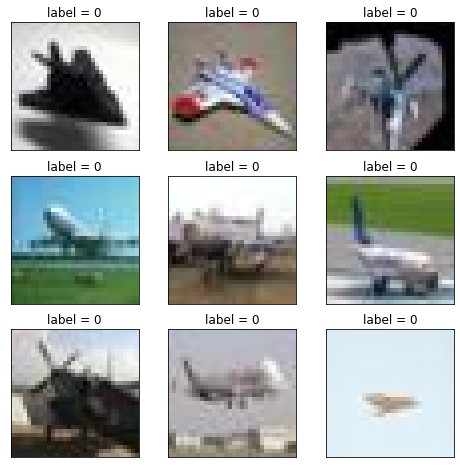

In [121]:
%matplotlib inline
%config InlineBackend.figure_fomat = 'svg' # 在默认设置的matplotlib中图片分辨率不是很高，可以通过设置矢量图的方式来提高图片显示质量

# 查看部分样本
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for i in range(9):
    img, label = ds_train[i]
    # permute是torch中的函数 将tensor的维度换位，参数是一系列的整数，代表原来张量的维度
    # 比如图片的size是（28，28，3），就可以利用img.permute（2，0，1）得到一个size为（3，28，28）的tensor
    img = img.permute(1,2,0)
    # subplot有多种用法 图中所示为 subplot（nrows， ncols， index）
    ax = plt.subplot(3,3,i+1) # 添加子图
    ax.imshow(img.numpy())
    ax.set_title('label = %d'%label.item())
    # 将坐标轴设置为空白的方法
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [122]:
# Pytorch的图片默认顺序是 Batch,Channel,Width,Height

for x,y in dl_train:
    print(x.shape,y.shape)
    break

torch.Size([50, 3, 32, 32]) torch.Size([50, 1])


使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器(nn.Sequential,nn.ModuleList,nn.ModuleDict)进行封装。

此处选择通过继承nn.Module基类构建自定义模型。

In [123]:
# 自适应最大池化 Adaptive Max Pooling
# 池化过程在一般卷积过程后。池化的本质就是采样。Pooling对于输入的Feature Map，选择某种方式对其降维压缩，以加快运算速度。
# 可以搜索池化相关知识
pool = nn.AdaptiveMaxPool2d((1,1))
t = torch.randn(10, 8, 32, 32) # 返回一个张量，包含了从标准正态分布（均值为0，方差为1）中随机抽取的一组随机数，张量的形状由参数sizes决定
pool(t).shape

torch.Size([10, 8, 1, 1])

此处构建Module的方法与1-1值得对比注意下

https://blog.csdn.net/qq_37385726/article/details/81740233

pytorch搭建神经网络的四种方法


In [124]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3)
        # 二维卷积处理二维数据 int_channel:输入数据的通道数，一般RGB图片的通道数为3
        # kernel_size 卷积核大小，可以是int,或turple; kennel_size=2，意味着卷积大小（2，2），kenel_size=(2,3),意味着卷积大小（2，3）即非正方形卷积
        # 池化层 采样层 实际上就是一个特征选择的过程
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # kernel_size: max pooling的窗口大小 strider： 窗口移动的步长，默认值是kernel_size
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        # 随机的将通道变为0，Dropout2d是根据伯努利分布概率的
        # p 概率
        # 在前向传播的时候，让某个神经元的激活值以一定的概率p停止工作，这样可以使模型的泛化性更强，因为它不会太依赖某些局部的特征
        self.dropout = nn.Dropout2d(p=0.1)
        # 自适应最大池化
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        # Flatten层用来将输入“压平”, 即把多维的输入一维化，常用在从卷积层到全连接层的过渡。
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64, 32) # 线性变换
        self.relu = nn.ReLU() # 激活函数
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten()
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [125]:
import torchkeras
torchkeras.summary(net, input_shape=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forwar

In [126]:
# 训练模型
import pandas as pd
from sklearn.metrics import roc_auc_score

model = net
model.optimizer = torch.optim.SGD(model.parameters(), lr = 0.01) # 随机梯度下降
model.loss_func = torch.nn.BCELoss()
model.metric_func = lambda y_pred, y_true: roc_auc_score(y_true.data.numpy(), y_pred.data.numpy())
model.metric_name = 'auc'

In [127]:
# 训练模型
def train_step(model, features, labels):

    # 训练模式 启用BatchNormalization和Dropout,将两者设为True,训练模块中必写
    model.train()

    # 梯度清零
    model.optimizer.zero_grad()

    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions, labels)
    metric = model.metric_func(predictions, labels)

    # 反向传播求梯度
    loss.backward()
    model.optimizer.step() # 这个方法是更新所有的参数

    return loss.item(), metric.item()


# 测试模型
def valid_step(model, features, labels):
    # 预测模式，关闭dropout
    model.eval()

    # 关闭梯度计算
    with torch.no_grad():
        predictions = net(features)
        loss = model.loss_func(predictions, labels)
        metric = model.metric_func(predictions, labels)

    return loss.item(), metric.item()

# next(iter())一个一个遍历，类似与文档的read（）
features,labels = next(iter(dl_train))
train_step(model,features,labels)



(0.7043229937553406, 0.5032467532467533)

In [128]:
# 完整的训练函数

def train_model(model, epochs, dl_train, dl_valid, log_step_freq):

    metric_name = model.metric_name
    dfhistory = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name])
    print('Start Training....')
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('========='*8 + '%s'%nowtime)
    for epoch in range(1, epochs+1):

        #1. 训练循环
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1

        for step, (features, labels) in enumerate(dl_train, 1):
            loss, metric = train_step(model, features, labels)
            # 打印batch级别日志
            loss_sum += loss
            metric_sum += metric
            if step%log_step_freq == 0:
                print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                      (step, loss_sum/step, metric_sum/step))


        # 2. 验证循环
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1

        for val_step, (features, labels) in enumerate(dl_valid, 1):

            val_loss, val_metric = valid_step(model, features, labels)

            val_loss_sum += val_loss
            val_metric_sum += val_metric


        # 3. 记录日志
        info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
        dfhistory.loc[epoch-1] = info

        # 打印epoch级别日志
        print(('\nEPOCH = %d, loss = %.3f, ' + metric_name + ' = %.3f, val_loss = %.3f, ' + 'val_' + metric_name + ' = %.3f')%info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print('\n' + '=========='*8 + '%s'%nowtime)

    print('Finished Training...')

    return dfhistory

In [129]:
epochs = 20
dfhistory = train_model(model, epochs, dl_train, dl_valid, log_step_freq=50)

Start Training....
========================================================================2020-10-23 22:36:10
[step = 50] loss: 0.695, auc: 0.524
[step = 100] loss: 0.693, auc: 0.578
[step = 150] loss: 0.693, auc: 0.608
[step = 200] loss: 0.691, auc: 0.637

EPOCH = 1, loss = 0.691, auc = 0.637, val_loss = 0.685, val_auc = 0.796

================================================================================2020-10-23 22:36:42
[step = 50] loss: 0.685, auc: 0.754
[step = 100] loss: 0.683, auc: 0.761
[step = 150] loss: 0.682, auc: 0.759
[step = 200] loss: 0.679, auc: 0.759

EPOCH = 2, loss = 0.679, auc = 0.759, val_loss = 0.667, val_auc = 0.813

================================================================================2020-10-23 22:36:51
[step = 50] loss: 0.665, auc: 0.789
[step = 100] loss: 0.661, auc: 0.787
[step = 150] loss: 0.658, auc: 0.781
[step = 200] loss: 0.651, auc: 0.784

EPOCH = 3, loss = 0.651, auc = 0.784, val_loss = 0.620, val_auc = 0.814

==========================

In [131]:
dfhistory

,epoch,loss,auc,val_loss,val_auc
0,1.0,0.691184,0.636621,0.685440,0.795936
1,2.0,0.679251,0.759152,0.666760,0.813134
2,3.0,0.651296,0.783790,0.619541,0.814404
3,4.0,0.596982,0.790657,0.550528,0.818659
4,5.0,0.555343,0.794656,0.518807,0.828737
5,6.0,0.533906,0.807917,0.500440,0.839987
6,7.0,0.523645,0.816095,0.494547,0.847792
7,8.0,0.513196,0.824775,0.481453,0.856389
8,9.0,0.501868,0.834108,0.471576,0.858444
9,10.0,0.492785,0.841427,0.467339,0.863818


In [133]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['train_' + metric, 'val_' + metric])
    plt.show()

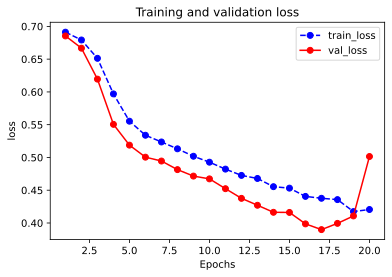

In [134]:
plot_metric(dfhistory, 'loss')

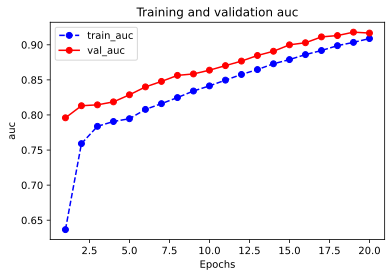

In [136]:
plot_metric(dfhistory, 'auc')

In [139]:
# 使用模型
# 这一步相当于
def predict(model, dl):
    model.eval()
    with torch.no_grad():
        result = torch.cat([model.forward(t[0]) for t in dl]) # 张量拼接 对于每一个数据进行计算
    return(result.data)

In [141]:
# 预测概率
y_pred_probs = predict(model, dl_valid)
y_pred_probs

tensor([[0.2787],
        [0.7009],
        [0.4206],
        ...,
        [0.6777],
        [0.8360],
        [0.8785]])

In [143]:
# 预测类别
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))
y_pred

tensor([[0.],
        [1.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

In [144]:
# 保存模型
# 保存参数
torch.save(model.state_dict(), './model_parameter.pkl')

net_clone = Net()
net_clone.load_state_dict(torch.load('./model_parameter.pkl'))

predict(net_clone, dl_valid)

tensor([[0.0914],
        [0.3030],
        [0.3807],
        ...,
        [0.9344],
        [0.0986],
        [0.3104]])